## Additional Preprocessing

In [ ]:
!pip install catboost

In [ ]:
!pip install category_encoders

In [38]:
import os
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

In [23]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from catboost import CatBoostClassifier
from category_encoders import CountEncoder
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression

In [7]:
df = pd.read_csv("Train_fe.csv")

In [8]:
label_encoder = LabelEncoder()
df['Target'] = label_encoder.fit_transform(df['Target'])
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

corr_matrix = df[numerical_cols].corr()

target_corr = corr_matrix['Target'].sort_values(ascending=False)

print(target_corr.sort_values())

CompPart                     -0.925893
Sub                          -0.314370
Num_Comp_Per_Month           -0.168394
Num_Comp_Per_Month_trend     -0.135299
Disc                         -0.126705
                                ...   
Total_Num_User_Months_mean    0.122848
Total_Num_User_Months         0.125577
Target                        1.000000
is_train                           NaN
Record                             NaN
Name: Target, Length: 71, dtype: float64


As can be seen, there are one feature that strongly correlates with our target variable -- **CompPart**.  
In order to improve a model's ability to generalize to new data, reduce the risk of overfitting and make the model more robust, we remove this feature from the train set along with target variable.

In [10]:
X = df.drop(['Target', 'CompPart'], axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_cols = list(set(X_train.columns[X_train.dtypes == 'object']) - set(['User_ID']) - set (['Country']))

X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

In [11]:
X_train_encoded.drop(['User_ID', 'Country', 'Unnamed: 0'], axis=1, inplace=True)
X_test_encoded.drop(['User_ID', 'Country', 'Unnamed: 0'], axis=1, inplace=True)

## Classifiers

In [27]:
def train_with_folds(X_train, X_test, y_train, y_test, model_name='LGB'):

  if model_name == 'LGB':
    model = lgb.LGBMClassifier(boosting_type='gbdt', objective='multiclass', num_class=3, random_state=42)
    acc_test, auc_test = train_and_predict(X_train, X_test, y_train, y_test, model)

  elif model_name == 'XGB':
    params = {'n_estimators': 200, 'random_state': 123, 'learning_rate': 0.01, 'colsample_bytree': 0.3, 'max_depth': 6}
    model = xgb.XGBClassifier(**params)

    acc_test, auc_test = train_and_predict(X_train, X_test, y_train, y_test, model)
  elif model_name == "log_reg":
    model = LogisticRegression(multi_class='ovr', solver='liblinear')

    X_train_dropped = X_train.dropna()
    X_test_dropped = X_test.dropna()

    y_train_dropped = y_train.loc[X_train_dropped.index]
    y_test_dropped = y_test.loc[X_test_dropped.index]

    model.fit(X_train_dropped, y_train_dropped)

    y_test_pred = model.predict(X_test_dropped)
    y_test_prob = model.predict_proba(X_test_dropped)

    acc_test = accuracy_score(y_test_dropped, y_test_pred)
    auc_test = roc_auc_score(y_test_dropped, y_test_prob, multi_class='ovr', average='macro')

  else:
    raise ValueError(f"Unsupported model name: {model_name}")

  return acc_test, auc_test


In [18]:
def train_and_predict(X_train, X_test, y_train, y_test, model, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_accuracies = []
    fold_auc_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
      print(f"Training fold {fold + 1}/{n_splits}...")

      X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]

      y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
      y_val_fold = pd.Series(y_val_fold)
      y_train_fold = pd.Series(y_train_fold)


      model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)])

      y_val_pred = model.predict(X_val_fold)
      y_val_prob = model.predict_proba(X_val_fold)

      val_accuracy = accuracy_score(y_val_fold, y_val_pred)
      fold_accuracies.append(val_accuracy)

      val_auc = roc_auc_score(y_val_fold, y_val_prob, multi_class='ovr', average='macro')
      fold_auc_scores.append(val_auc)

      print(f"Fold {fold + 1} Accuracy: {val_accuracy:.4f}, AUC: {val_auc:.4f}")

    mean_accuracy = np.mean(fold_accuracies)
    mean_auc = np.mean(fold_auc_scores)

    print(f"\nMean Accuracy across all folds: {mean_accuracy:.4f}")
    print(f"Mean AUC across all folds: {mean_auc:.4f}")

    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr', average='macro')

    print(f"\nTest Set Accuracy: {test_accuracy:.4f}")
    print(f"Test Set AUC: {test_auc:.4f}")

    return test_accuracy, test_auc


In [19]:
xgb_acc, xgb_auc = train_with_folds(X_train_encoded, X_test_encoded, y_train, y_test, model_name='XGB')

Training fold 1/5...
[0]	validation_0-mlogloss:1.08702
[1]	validation_0-mlogloss:1.07582
[2]	validation_0-mlogloss:1.06471
[3]	validation_0-mlogloss:1.05424
[4]	validation_0-mlogloss:1.04361
[5]	validation_0-mlogloss:1.03248
[6]	validation_0-mlogloss:1.02151
[7]	validation_0-mlogloss:1.01099
[8]	validation_0-mlogloss:1.00069
[9]	validation_0-mlogloss:0.99106
[10]	validation_0-mlogloss:0.98155
[11]	validation_0-mlogloss:0.97229
[12]	validation_0-mlogloss:0.96321
[13]	validation_0-mlogloss:0.95422
[14]	validation_0-mlogloss:0.94544
[15]	validation_0-mlogloss:0.93677
[16]	validation_0-mlogloss:0.92800
[17]	validation_0-mlogloss:0.91912
[18]	validation_0-mlogloss:0.91039
[19]	validation_0-mlogloss:0.90234
[20]	validation_0-mlogloss:0.89385
[21]	validation_0-mlogloss:0.88587
[22]	validation_0-mlogloss:0.87820
[23]	validation_0-mlogloss:0.87009
[24]	validation_0-mlogloss:0.86258
[25]	validation_0-mlogloss:0.85492
[26]	validation_0-mlogloss:0.84772
[27]	validation_0-mlogloss:0.84065
[28]	vali

In [20]:
xgb_acc

0.9074412608001231

In [28]:
logreg_acc, logreg_auc = train_with_folds(X_train_encoded, X_test_encoded, y_train, y_test, model_name='log_reg')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [30]:
lgb_acc, lgb_auc = train_with_folds(X_train_encoded, X_test_encoded, y_train, y_test, model_name='LGB')

Training fold 1/5...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6747
[LightGBM] [Info] Number of data points in the train set: 166292, number of used features: 69
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.114818
[LightGBM] [Info] Start training from score -0.150174
[LightGBM] [Info] Start training from score -3.974631
Fold 1 Accuracy: 0.9263, AUC: 0.9534
Training fold 2/5...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And

In [35]:
models = ['LGBmClassifier', 'XGBoostClassifier', 'Logistic Regression']

plot_foundation = {}
for i in models:
  plot_foundation[i] = {'acc': 0, 'auc': 0}

In [36]:
plot_foundation['LGBmClassifier']['acc'] = lgb_acc
plot_foundation['LGBmClassifier']['auc'] = lgb_auc

plot_foundation['XGBoostClassifier']['acc'] = xgb_acc
plot_foundation['XGBoostClassifier']['auc'] = xgb_auc

plot_foundation['Logistic Regression']['acc'] = logreg_acc
plot_foundation['Logistic Regression']['auc'] = logreg_auc

In [37]:
plot_foundation


{'LGBmClassifier': {'acc': 0.9253757192064195, 'auc': 0.9551512308111336},
 'XGBoostClassifier': {'acc': 0.9074412608001231, 'auc': 0.9478436899255008},
 'Logistic Regression': {'acc': 0.9418103448275862, 'auc': 0.8931425982484335}}

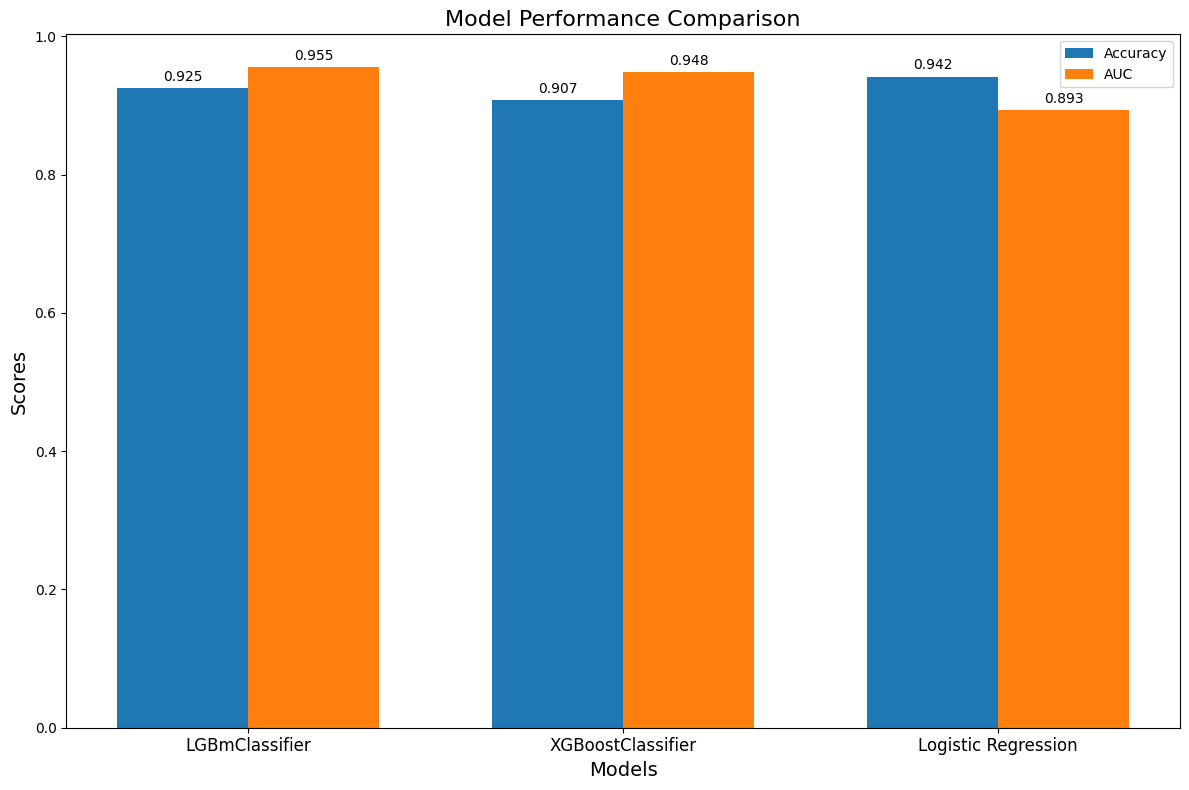

In [44]:
models = list(plot_foundation.keys())
accuracy = [plot_foundation[model]['acc'] for model in models]
auc = [plot_foundation[model]['auc'] for model in models]

# Set up bar width and x locations
bar_width = 0.35
x = np.arange(len(models))

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - bar_width/2, accuracy, bar_width, label='Accuracy')
bars2 = ax.bar(x + bar_width/2, auc, bar_width, label='AUC')

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Model Performance Comparison', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend()

# Adding value labels on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()